In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score

import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from lingam import DirectLiNGAM, BottomUpParceLiNGAM, VARLiNGAM
from lingam import CausalBasedSimulator
from lingam.utils import make_dot

np.random.seed(0)

## 1. 実験用関数

### 1.1. 因果デジタルツインのクラス

In [2]:
class CausalDigitalTwin:
    
    def __init__(self, causal_graph, X, sink_index, is_discrete=None):
        cd_algo_name = "VARLiNGAM" if len(causal_graph.shape) > 2 else "DirectLiNGAM"
        
        sim = CausalBasedSimulator()
        sim.train(X, causal_graph, cd_algo_name=cd_algo_name, is_discrete=is_discrete)
        
        self._sim = sim
        self._causal_graph = causal_graph
        self._X = X
        self._sink_index = sink_index
        self._is_discrete = is_discrete
    
    def run(self, ml_models, causal_graph=None, error=None, shuffle_residual=False):
        """
        Arguments
        ---------
        causal_graph : array-like
        error : dict
        ml_models : dict
        
        Return
        ------
        evaluated
        """
        
        if causal_graph is None:
            changing_models = None
        else:
            changing_models = self._make_changing_models(self._causal_graph, causal_graph)
            
        if error is None: 
            changing_exog = None
        else:
            changing_exog = {i: error[:, i].ravel() for i in range(error.shape[1])}
        
        print("changing_models:", changing_models)
        print("changing_exog:", changing_exog)
        simulated = self._sim.run(changing_models=changing_models, changing_exog=changing_exog, shuffle_residual=shuffle_residual)

        evals, predicted_values = self._evaluate(self._X, simulated, self._sink_index, ml_models, self._is_discrete)
        
        return evals, predicted_values, simulated
    
    def _make_changing_models(self, causal_graph, causal_graph2):
        # グラフの構造の変化からchanging_modelsを作成する。
        changed = ~np.isclose(causal_graph - causal_graph2, 0)

        # 説明変数の係数に変化を含む行を対象として処理
        changing_models = {}
        for i, row in enumerate(changed):
            # 変化なしはパス
            if np.isclose(np.sum(row), 0):
                continue

            # 変更後のDAGに従って親変数とその係数値を改めて設定する。
            parent_indices = np.argwhere(~np.isclose(causal_graph2[i], 0)).ravel()
            parent_names = [f"{i}" for i in parent_indices]
            coefs = causal_graph2[i, parent_indices] if len(parent_indices) != 0 else []
            changing_models[f"{i}"] = {"parent_names": parent_names, "coef": coefs}
        if len(changing_models) == 0:
            changing_models = None
            
        return changing_models
    
    def _evaluate(self, X, simulated, sink_index, ml_models, is_discrete):     
        evals = {}
        predicted_values = {}
        for name, ml_model in ml_models.items():
            # 変更前データの機械学習
            X_ = np.delete(X, sink_index, axis=1)
            y_ = X[:, sink_index]
            ml_model.fit(X_, y_)
            predicted = ml_model.predict(X_)

            # 変更後シミュレーションデータの機械学習
            X_ = np.delete(simulated, sink_index, axis=1)
            y_ = simulated.iloc[:, sink_index]
            ml_model.fit(X_, y_)
            predicted2 = ml_model.predict(X_)

            # 評価
            if is_discrete is None or not is_discrete[sink_index]:
                eval_funcs = [("mse", mean_squared_error)]
            else:
                eval_funcs = [("precision", precision_score), ("recall", recall_score)]
                
            for eval_name, eval_func in eval_funcs:
                # 変更前：真のデータに基づく機械学習モデルの予測結果と、真のデータの評価値
                eval_value = eval_func(X[:, sink_index], predicted)
                evals[(name, eval_name, "true")] = eval_value

                # 変更後：シミュレーションデータに基づく機械学習モデルの予測結果と、真のシミュレーションデータの評価値
                eval_value2 = eval_func(simulated.iloc[:, sink_index], predicted2)
                evals[(name, eval_name, "sim")] = eval_value2

            predicted_values[(name, "true")] = {"true": X[:, sink_index], "pred": predicted}
            predicted_values[(name, "sim")] = {"true": simulated.iloc[:, sink_index], "pred": predicted2}
        return evals, predicted_values

### 1.2. データ生成のための関数

In [3]:
def generate_test_data(causal_graph, causal_order, ratio_list, size=1000):
    """ 誤差項の分散が指定の割合になるように係数を調整しながらデータを生成する。
    
    Arguments
    ---------
    causal_graph
        因果グラフ
    raito_list
        各変数における誤差項の分散の割合
    causal_order
        因果順序
    e
        誤差項
    Return
    ------
    X
        データ
    causal_graph
        係数を調整した因果グラフ
    """
    n_features = len(causal_graph)
    
    # generate errors
    e = np.empty((n_features, size))
    for i, ratio in enumerate(ratio_list):
        a = np.sqrt(3 * ratio)
        e[i] = np.random.uniform(-a, a, size=size)

    # generate data
    X = np.zeros((n_features, size))
    for no in causal_order:
        if np.all(np.isclose(causal_graph[no], 0)):
            X[no] = e[no]
            continue
            
        # adjust coefs
        var = np.var(causal_graph[no] @ X)
        causal_graph[no] = causal_graph[no] / np.sqrt(var) * np.sqrt(1 - ratio_list[no])
    
        # generate
        X[no] = causal_graph[no] @ X + e[no]
    
    return X.T, causal_graph, e.T

def discretize(causal_graph, X, sink_index):
    """ X[:, sink_index] を離散化する。 """
    prob = expit(X[:, sink_index])
    mask = np.random.uniform(size=len(X))
    X[:, sink_index] = prob > mask
    return X

### 1.3. その他

In [4]:
def draw_data_hist(X, e):
    """ データのヒストグラム表示 """
    n_features = len(X.T)
    fig, axes = plt.subplots(2, n_features, figsize=(2*n_features, 2*2))
    for i in range(n_features):
        axes[0, i].hist(X[:, i])
        axes[0, i].set_title(f"x{i}, var={np.var(X[:, i]):.3f}")
        axes[1, i].hist(e[:, i])
        axes[1, i].set_title(f"e{i}, var={np.var(e[:, i]):.3f}")
    plt.tight_layout()
    plt.show()
    
def draw_hist(X, simulated):
    n_features = simulated.shape[1]
    fig, axes = plt.subplots(1, n_features, figsize=(n_features*2, 2))
    for i, (true, sim) in enumerate(zip(X.T, simulated.values.T)):
        range_ = min(*true, *sim), max(*true, *sim)
        axes[i].hist(true, range=range_, label="true", alpha=0.5)
        axes[i].hist(sim, range=range_, label="sim", alpha=0.5)
        axes[i].set_title(f"x{i}")
        if i == n_features - 1:
            axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## 1. DirectLiNGAM

### 1.1. データ作成

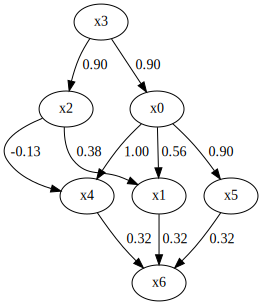

In [5]:
# 元の隣接行列は次と同じ：https://github.com/cdt15/lingam/blob/master/examples/DirectLiNGAM.ipynb
cg_not_adjusted = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])
# 因果順序
causal_order = [3, 0, 2, 1, 4, 5, 6]
# 各変数の分散に占める誤差項の分散の比率
ratio_list = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2]
# シンク変数のインデックス
sink_index = 6

# 係数の調整
X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, size=1000)

display(make_dot(causal_graph_true))

# データ生成関数
def data_gen_direct_lingam(causal_graph, error):
    X = (np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ errors.T).T
    return X, error

### 1.2. 実験

In [6]:
test_results = []

# 実験間で共通のデータ

# 誤差項
errors = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors.append(np.random.uniform(-a, a, size=1000))
errors = np.array(errors).T
    
errors2 = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors2.append(np.random.uniform(-a, a, size=1000))
errors2 = np.array(errors2).T

# 機械学習モデル
param_grid = {"n_estimators": [1, 2, 3]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 離散変数
is_discrete = [False for _ in range(len(causal_graph_true))]
is_discrete[sink_index] = True

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x3->x2を削除)
causal_graph = causal_graph_true.copy()
causal_graph[2, 3] = 0

test_info.append({
    "name": "1: remove an edge",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x0->x2を追加)
causal_graph = causal_graph_true.copy()
causal_graph[2, 0] = 1

test_info.append({
    "name": "2: add an edge",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x2->x1を倍に設定)
causal_graph = causal_graph_true.copy()
causal_graph[1, 2] *= 2

test_info.append({
    "name": "3: modify an edge value",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    X, error_ = data_gen_direct_lingam(causal_graph_true, errors)
    cdt = CausalDigitalTwin(causal_graph_true, X, sink_index)
    result = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"])
    
    # sinkが連続&シャッフル
    result_shuffle = cdt.run(ml_models_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    X, error_ = data_gen_direct_lingam(causal_graph_true, errors)
    X = discretize(causal_graph, X, sink_index)
    cdt = CausalDigitalTwin(causal_graph_true, X, sink_index, is_discrete=is_discrete)
    result_d = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"])
    
    # sinkが離散&シャッフル
    result_d_shuffle = cdt.run(ml_models_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    results[info["name"]] = {
        "continuous": result,
        "continuous_shuffle": result_shuffle,
        "discrete": result_d,
        "discrete_shuffle": result_d_shuffle,
    }

changing_models: {'2': {'parent_names': [], 'coef': []}}
changing_exog: None
changing_models: {'2': {'parent_names': [], 'coef': []}}
changing_exog: None
changing_models: {'2': {'parent_names': [], 'coef': []}}
changing_exog: None
changing_models: {'2': {'parent_names': [], 'coef': []}}
changing_exog: None
changing_models: {'2': {'parent_names': ['0', '3'], 'coef': array([1.        , 0.90245353])}}
changing_exog: None
changing_models: {'2': {'parent_names': ['0', '3'], 'coef': array([1.        , 0.90245353])}}
changing_exog: None
changing_models: {'2': {'parent_names': ['0', '3'], 'coef': array([1.        , 0.90245353])}}
changing_exog: None
changing_models: {'2': {'parent_names': ['0', '3'], 'coef': array([1.        , 0.90245353])}}
changing_exog: None
changing_models: {'1': {'parent_names': ['0', '2'], 'coef': array([0.56468239, 0.75290985])}}
changing_exog: None
changing_models: {'1': {'parent_names': ['0', '2'], 'coef': array([0.56468239, 0.75290985])}}
changing_exog: None
changing

## 2. BottomUpParceLiNGAM

※データ生成時、未観測共通原因をないことにして、誤差項もそのままだと分散の大きさが変数ごとに違ってしまう。

### 2.1. データ作成

DirectLiNGAMと同じ構造でデータを作成し、その後、x3を未観測化する。

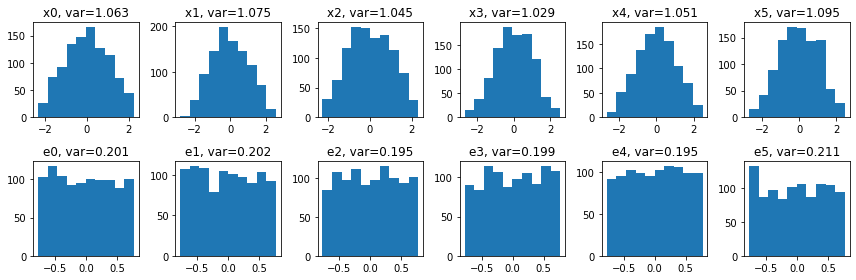

In [7]:
cg_not_adjusted = np.array([
    [0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [8.0, 0.0,-1.0, 0.0, 0.0, 0.0, 0.0],
    [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0],
])
causal_order = [3, 0, 2, 1, 4, 5, 6]
ratio_list = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.2]
X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, size=1000)

# DirectLiNGAMとまったく同じなので省略

# 未観測化
delete_index = 3

# データ生成関数：未観測化はこの関数内で行う
def data_gen_unobs_common(causal_graph, errors):
    delete_index = 3
    
    X = (np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ errors.T).T
    X = np.delete(X, delete_index, axis=0)
    X = np.delete(X, delete_index, axis=1)
    
    errors = np.delete(errors, delete_index, axis=1)
    
    return X, errors

errors = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors.append(np.random.uniform(-a, a, size=1000))
errors = np.array(errors).T

X, errors = data_gen_unobs_common(causal_graph_true, errors)
draw_data_hist(X, errors)

唯一の外生変数だったx3が消えて誤差項と分布が一致する変数が居なくなった。

### 2.2. 実験

## 3. VARLiNGAM

### 3.1. データ作成

In [8]:
# 元の隣接行列は次と同じ：https://github.com/cdt15/lingam/blob/master/examples/VARLiNGAM.ipynb
causal_graph_true = np.array([
    [
        [0,-0.12,0,0,0],
        [0,0,0,0,0],
        [-0.41,0.01,0,-0.02,0],
        [0.04,-0.22,0,0,0],
        [0.15,0,-0.03,0,0],
    ],
    [
        [-0.32,0,0.12,0.32,0],
        [0,-0.35,-0.1,-0.46,0.4],
        [0,0,0.37,0,0.46],
        [-0.38,-0.1,-0.24,0,-0.13],
        [0,0,0,0,0],
    ]
])
#display(pd.DataFrame(causal_graph_true[0], columns=[f"x{i}[t]" for i in range(5)], index=[f"x{i}[t]" for i in range(5)]))
#display(pd.DataFrame(causal_graph_true[1], columns=[f"x{i}[t-1]" for i in range(5)], index=[f"x{i}[t]" for i in range(5)]))

causal_order = [1, 0, 3, 2, 4]
ratio_list = [0.2, 0.2, 0.2, 0.2, 1.0]

n_features = cg_not_adjusted.shape[1]
n_lags = len(cg_not_adjusted) - 1

# VARの分散を調整することはできない。そもそも確率過程である。
if False:
    cg_not_adjusted = causal_graph_true
    
    # DirectLiNGAMと同じ形式に変換する
    cg_not_adjusted = np.concatenate(cg_not_adjusted, axis=1)
    cg_not_adjusted = np.concatenate([cg_not_adjusted, np.zeros(cg_not_adjusted.shape)], axis=0)
    cg_not_adjusted[-n_features:, -n_features:] = cg_not_adjusted[:n_features, :n_features]
    col_names = [f"x{i}[t]" for i in range(5)] + [f"x{i}[t-1]" for i in range(5)]
    display(pd.DataFrame(cg_not_adjusted, columns=col_names, index=col_names))

    causal_order = [no + len(causal_order) for no in causal_order] + causal_order

    ratio_list = [0.2 for _ in range(len(cg_not_adjusted))]
    # 前時刻のx1のみが外生変数になる。
    ratio_list[n_features + 1] = 1

    # generate errors
    size = 1000 + n_lags
    e = np.empty((n_features, size))
    for i, ratio in enumerate(ratio_list):
        a = np.sqrt(3 * ratio)
        e[i] = np.random.uniform(-a, a, size=size)
    e = np.vstack([e[:, n_lags:], e[:, :-n_lags]])
    #e = np.vstack([e[:, n_lags:]] + [e[:, :-(i + 1)] for i in range(n_lags)])
    print(e.shape)

    # この方法で作り出したデータは使えない。前時点の列と現時点のデータ列のひとつまえが一致しないため。
    X, causal_graph_true, e_true = generate_test_data(cg_not_adjusted, causal_order, ratio_list, e, size=size)
    # Xとeは使えないが見ておく。
    draw_data_hist(X, e_true)

    # 隣接行列の上半分を使用する。上半分を時点ごとの隣接行列に分割して、元と同じ形にする。
    causal_graph_true = causal_graph_true[:n_features]
    causal_graph_true = np.array([causal_graph_true[:, :n_features], causal_graph_true[:, n_features:]])

def data_gen_time_series(causal_graph, errors):
    def x_t(X, e, B):
        _, n_features, _ = B.shape
        
        # (I - B_0)^-1
        term = np.linalg.pinv(np.eye(n_features) - B[0])

        # Sigma[B_tau @ x(t-tau)] + e(t)
        # Bは横につなげて、Xは縦につなげる
        # Bの2番目以降を横に連結、Xの最新からBの2番目以降との積をとる部分を縦に連結して、行列の積
        term2 = np.hstack(B[1:]) @ np.hstack(X[:, ::-1][:, :len(B) - 1]).reshape(n_features, 1) + e

        return term @ term2
    
    sample_size = 1000
    
    n_lags = len(causal_graph) - 1
    size = len(errors) - n_lags
    
    X = errors[:, :n_lags]
    for t in range(n_lags, sample_size):
        new_data = x_t(X[:, :t], errors[:, [t]], causal_graph)
        X = np.append(X, new_data, axis=1)
    
    return X.T, errors.T

errors = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    errors.append(np.random.uniform(-a, a, size=1000))
errors = np.array(errors)

X, errors = data_gen_time_series(causal_graph_true, errors)
print(X.shape, errors.shape)



(1000, 5) (1000, 5)
